# Changes in local dynamics around the phosphosite
Here, we inspect if there differential changes in dynamics in the vicinity of the phosphosite, as compared to hte rest of the structure

In [17]:
import sys
sys.path.extend(["../code/src"])
from pathlib import Path
from Bio.PDB import PDBParser
from collections import Counter, defaultdict

from math import log2

import pandas as pd
import numpy as np
from scipy.stats import kstest, fisher_exact, boschloo_exact
from statsmodels.stats.multitest import multipletests
from Bio.PDB import PDBParser

from utils.structure import calc_intra_dist_matrix, get_contact_matrix, extract_sequence_from_chain
from utils.fasta import parse_fasta, write_fasta, concatenate_fastas
from utils.alignment import align, map_seq_to_alignment
from utils.subs_mtx import BLOSUM62_LOOKUP
from utils.mappings import PHOSPHO_RESIDUES_ONE
from utils.commands import call_pdbtofasta, call_muscle
from predict_status.helper import map_seqs_to_alignment

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [18]:
out_path = Path("psite_local_dynamics")
out_path.mkdir(exist_ok=True)

In [26]:
rmsips_df_nodups_single = pd.read_csv('global_dynamics_overview/rmsips_df_nodups_single.csv')
unique_psites = list(rmsips_df_nodups_single["phosphosite"].unique())

In [27]:
psite_dynamics_df = pd.read_csv("../results/local_psite_dynamics_12aa/psite_dynamics_diffs.csv",index_col=0)
psite_dynamics_df = psite_dynamics_df.loc[psite_dynamics_df["phosphosite"].isin(unique_psites)]

contact_df = pd.read_csv("../results/local_psite_dynamics_12aa/contact_residue_counts.df",index_col=0)
background_df = pd.read_csv("../results/local_psite_dynamics_12aa/background_residue_counts.df",index_col=0)

In [28]:
psite_dynamics_df

,phosphosite,ks_statistic,pval,background_median,background_std,contacts_median,contacts_std,reject,adj_pval,-log10_adj_pval
0,Q92630_458,0.541415,0.000337,-0.009041,0.165912,-0.043753,0.093897,True,0.001348,2.870252
1,Q9L387_85,0.204657,0.052856,-0.003599,0.062932,0.000596,0.030481,False,0.086491,1.063027
2,Q9F4L3_28,0.344969,0.006027,0.009323,0.046306,0.003448,0.015767,True,0.013998,1.853940
3,P05132_11,0.204995,0.383737,0.010787,0.079606,0.006433,0.025449,False,0.431705,0.364813
4,A0A1C3NEV1_283,0.340932,0.000274,-0.012392,0.607157,-0.002167,0.022990,True,0.001197,2.922067
...,...,...,...,...,...,...,...,...,...,...
138,P96356_78,0.132912,0.512088,-0.003654,0.146078,-0.004001,0.042600,False,0.554442,0.256144
139,P08877_15,0.127273,0.869524,0.008785,0.105174,0.011665,0.102154,False,0.894368,0.048484
140,P08879_119,0.266535,0.022277,0.012433,0.044620,0.009946,0.010595,True,0.042210,1.374586
141,P11309_276,0.269841,0.161935,-0.011248,0.058339,-0.012038,0.012631,False,0.224218,0.649329


In [29]:
diffs = psite_dynamics_df['contacts_median'] - psite_dynamics_df['background_median']
psite_dynamics_df['diffs'] = diffs

In [30]:
# Remove duplicates
# Re-do multiple testing correction after removing duplicates
adj_pvals = multipletests(list(psite_dynamics_df['pval'].values), alpha=0.05, 
                          method='fdr_bh')
psite_dynamics_df['reject'] = adj_pvals[0]
psite_dynamics_df['adj_pval'] = adj_pvals[1]
psite_dynamics_df['-log10_adj_pval'] = -np.log10(psite_dynamics_df['adj_pval'])


In [31]:
colors = []
direction_change = []
sig_threshold = -np.log10(0.05)
for idx, row in psite_dynamics_df.iterrows():
    pval = row['-log10_adj_pval']
    diff = row['diffs']
    if pval > sig_threshold and diff > 0:
        colors.append('tab:red')
        direction_change.append('increase')
    elif pval > sig_threshold and diff < 0:
        colors.append('tab:blue')
        direction_change.append('decrease')
    else:
        colors.append('tab:gray')
        direction_change.append('no change')

Text(0.5, 0, 'Median difference contacts - median difference background \n (phosphorylated - non-phosphorylated)')

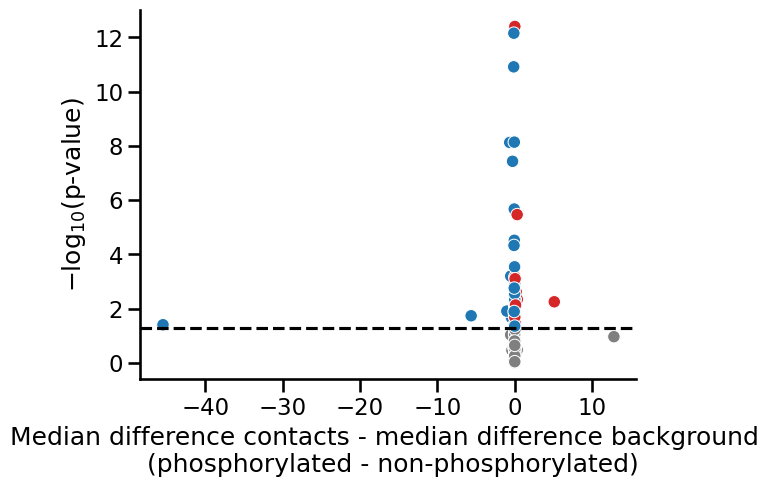

In [32]:
sns.set_context('talk')
sns.scatterplot(data=psite_dynamics_df, y='-log10_adj_pval', x='diffs',c=colors)
sns.despine()
plt.axhline(-np.log10(0.05), ls='--', color='black')
plt.ylabel('$-\log_{10}$(p-value)')
plt.xlabel('Median difference contacts - median difference background \n (phosphorylated - non-phosphorylated)')
plt.savefig(out_path / "psite_local_dynamics.png", dpi=120, bbox_inches='tight')

In [33]:
psite_dynamics_df

,phosphosite,ks_statistic,pval,background_median,background_std,contacts_median,contacts_std,reject,adj_pval,-log10_adj_pval,diffs
0,Q92630_458,0.541415,0.000337,-0.009041,0.165912,-0.043753,0.093897,True,0.001820,2.739918,-0.034712
1,Q9L387_85,0.204657,0.052856,-0.003599,0.062932,0.000596,0.030481,False,0.089194,1.049663,0.004195
2,Q9F4L3_28,0.344969,0.006027,0.009323,0.046306,0.003448,0.015767,True,0.015498,1.809736,-0.005875
3,P05132_11,0.204995,0.383737,0.010787,0.079606,0.006433,0.025449,False,0.418623,0.378177,-0.004354
4,A0A1C3NEV1_283,0.340932,0.000274,-0.012392,0.607157,-0.002167,0.022990,True,0.001643,2.784486,0.010225
...,...,...,...,...,...,...,...,...,...,...,...
138,P96356_78,0.132912,0.512088,-0.003654,0.146078,-0.004001,0.042600,False,0.542211,0.265831,-0.000347
139,P08877_15,0.127273,0.869524,0.008785,0.105174,0.011665,0.102154,False,0.894368,0.048484,0.002880
140,P08879_119,0.266535,0.022277,0.012433,0.044620,0.009946,0.010595,True,0.043745,1.359073,-0.002487
141,P11309_276,0.269841,0.161935,-0.011248,0.058339,-0.012038,0.012631,False,0.224218,0.649329,-0.000790


In [35]:
# Among significant cases, what's the extent of the changes?
psite_dynamics_df_reject = psite_dynamics_df.loc[psite_dynamics_df["reject"]==True]
psite_dynamics_df_reject["diffs"].median()

-0.007597465630663799

In [13]:
psite_dynamics_df.to_csv(out_path / "psite_dynamics_df.csv")

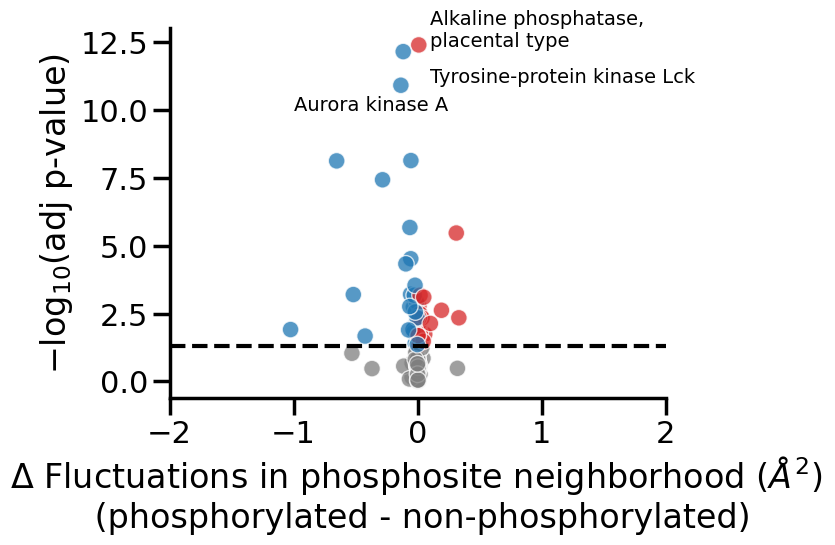

In [36]:
sns.set_context('poster')
sns.scatterplot(data=psite_dynamics_df, y='-log10_adj_pval', x='diffs',c=colors,
                alpha=.75)
sns.despine()
plt.axhline(-np.log10(0.05), ls='--', color='black')
plt.ylabel('$-\log_{10}$(adj p-value)')
# Median difference contacts - median difference background
plt.xlabel('Δ Fluctuations in phosphosite neighborhood ($Å^2$) \n (phosphorylated - non-phosphorylated)')
plt.xlim(-2,2)
#plt.xlim(-2,2)

# P05187_114
plt.text(0.1,12.34,"Alkaline phosphatase,\nplacental type",fontsize=14)
# P06239_394
plt.text(0.1,11,"Tyrosine-protein kinase Lck",fontsize=14)
# O14965_288
plt.text(-1,10,"Aurora kinase A",fontsize=14)

plt.savefig(out_path / "zoom_psite_local_dynamics.pdf", dpi=120, bbox_inches='tight')

In [37]:
passed_df = psite_dynamics_df.loc[psite_dynamics_df["reject"]==True]
print(f"{len(passed_df)} out of {len(psite_dynamics_df)}")
print("How many are more dynamic after phosphorylation?")
print(len(passed_df.loc[passed_df["diffs"]>0]))
print("How many are less dynamic after phosphorylation?")
print(len(passed_df.loc[passed_df["diffs"]<0]))

56 out of 108
How many are more dynamic after phosphorylation?
24
How many are less dynamic after phosphorylation?
32


In [38]:
psites_increased = list(passed_df.loc[passed_df["diffs"]>0]["phosphosite"])
psites_decreased = list(passed_df.loc[passed_df["diffs"]<0]["phosphosite"])

In [39]:
direction_counter = Counter(direction_change)

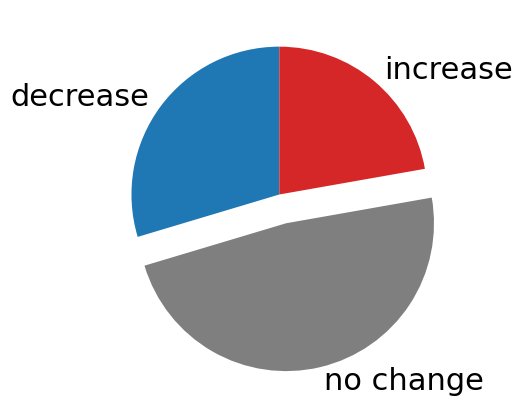

In [53]:
values =  list(direction_counter.values())
labels = list(direction_counter.keys())
colors = ["tab:blue","tab:gray","tab:red"]
explode = [0,0.2,0]

plt.pie(values, labels = labels, startangle = 90,explode=explode,colors=colors)
plt.savefig(out_path / "local_psite_dynamics_changes_piechart.pdf",dpi=120,bbox_inches='tight')

# Do the differences depend on the residues around each psite?
There are some statistically significant findings, but intuitively they don't quite make sense

In [54]:
# Try also a reduced aminoacid alphabet to boost the signal
groups = {
    1: ['I', 'M', 'L', 'V'],
    2: ['D', 'N'],
    3: ['F', 'Y'],
    4: ['A', 'G', 'S', 'T'],
    5: ['K', 'R'],
    6: ['Q', 'E'],
    7: ['P'],
    8: ['C'],
    9: ['H'],
    10: ['W']}

# Create the dictionary that maps each residue to its group
residue_to_group = {residue: group for group, residues in groups.items() for residue in residues}
print(residue_to_group)

{'I': 1, 'M': 1, 'L': 1, 'V': 1, 'D': 2, 'N': 2, 'F': 3, 'Y': 3, 'A': 4, 'G': 4, 'S': 4, 'T': 4, 'K': 5, 'R': 5, 'Q': 6, 'E': 6, 'P': 7, 'C': 8, 'H': 9, 'W': 10}


In [55]:
contact_df.fillna(value=0,inplace=True)
background_df.fillna(value=0,inplace=True)

In [56]:
columns = sorted(contact_df.columns)
contact_df = contact_df[columns]
background_df = background_df[columns]

In [57]:
full_set = list(contact_df.index)
changed_psites = set(psites_increased).union(psites_decreased)
nochange_psites = set(full_set).difference(changed_psites)


In [58]:
contact_counts_inc = contact_df.loc[list(psites_increased)].sum()
contact_counts_dec = contact_df.loc[list(psites_decreased)].sum()
contact_counts_nochange = contact_df.loc[list(nochange_psites)].sum()

background_inc = contact_counts_nochange + contact_counts_dec
background_dec = contact_counts_nochange + contact_counts_inc


In [59]:
def translate_to_reduced_alphabet(original_set, mapping):
    """
    """
    
    reduced_alphabet_counts = defaultdict(int)
    original_set = original_set.to_dict()
    for k,v in original_set.items():
        group = mapping[k]
        reduced_alphabet_counts[group] += v
    
    return reduced_alphabet_counts


In [60]:
reduced_contact_counts_inc = translate_to_reduced_alphabet(contact_counts_inc, residue_to_group)
reduced_contact_counts_dec = translate_to_reduced_alphabet(contact_counts_dec, residue_to_group)

reduced_background_inc = translate_to_reduced_alphabet(background_inc, residue_to_group)
reduced_background_dec = translate_to_reduced_alphabet(background_dec, residue_to_group)

In [61]:
def test_enrichment(contact_aas, background_aas):
    total_contact_aas = sum(contact_aas.values())
    total_background_aas = sum(background_aas.values())
    aas = list(contact_aas.keys())
    aa_to_result = {}
    for aa in aas:
        contact_aa_counts = contact_aas[aa]
        background_aa_counts = background_aas[aa]
        table = [[contact_aa_counts,(total_contact_aas - contact_aa_counts)],
                 [background_aa_counts,(total_background_aas - background_aa_counts)]]
        stat,pval = fisher_exact(table,alternative='greater')
        aa_to_result[aa] = pval
    return aa_to_result

def get_residue_log2fc(contact_counts, background_counts):
    residue_to_log2fc = {}
    for k, contact_count in contact_counts.items():
        background_count = background_counts[k]
        ratio = contact_count / background_count
        residue_to_log2fc[k] = ratio
        
    return residue_to_log2fc

    

In [62]:
aa_dec_to_result = test_enrichment(reduced_contact_counts_dec, reduced_background_dec)
aa_inc_to_result = test_enrichment(reduced_contact_counts_inc, reduced_background_inc)
adj_pval_dec = multipletests(list(aa_dec_to_result.values()),method="fdr_bh")
adj_pval_inc = multipletests(list(aa_inc_to_result.values()),method="fdr_bh")


In [63]:
residue_to_log2fc_dec = get_residue_log2fc(reduced_contact_counts_dec, reduced_background_dec)
residue_to_log2fc_inc = get_residue_log2fc(reduced_contact_counts_inc, reduced_background_inc)

residue_to_log2fc_dec_df = pd.DataFrame.from_dict(residue_to_log2fc_dec,orient="index")
residue_to_log2fc_inc_df = pd.DataFrame.from_dict(residue_to_log2fc_inc,orient="index")

residue_to_log2fc_dec_df.rename({0:'residue_ratio'},axis=1,inplace=True)
residue_to_log2fc_inc_df.rename({0:'residue_ratio'},axis=1,inplace=True)

In [64]:
aa_dec_to_result_df = pd.DataFrame.from_dict(aa_dec_to_result,orient="index")
aa_inc_to_result_df = pd.DataFrame.from_dict(aa_inc_to_result,orient="index")

aa_dec_to_result_df = aa_dec_to_result_df.rename({0:'adj_pval'},axis=1)
aa_inc_to_result_df = aa_inc_to_result_df.rename({0:'adj_pval'},axis=1)

aa_dec_to_result_df = aa_dec_to_result_df.sort_values(by='adj_pval')
aa_inc_to_result_df = aa_inc_to_result_df.sort_values(by='adj_pval')

In [65]:
merged_dec = aa_dec_to_result_df.merge(residue_to_log2fc_dec_df,on=aa_dec_to_result_df.index)
merged_inc = aa_inc_to_result_df.merge(residue_to_log2fc_inc_df,on=aa_inc_to_result_df.index)

In [66]:
merged_dec["-log10_adj_pval"] = -np.log10(merged_dec["adj_pval"])
merged_inc["-log10_adj_pval"] = -np.log10(merged_inc["adj_pval"])

merged_dec["key_0"] = merged_dec["key_0"].astype(str)
merged_inc["key_0"] = merged_inc["key_0"].astype(str)


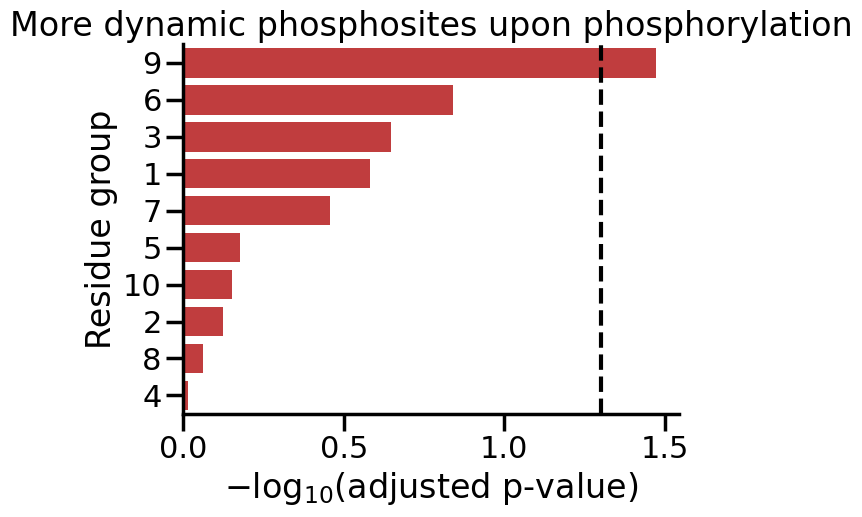

In [67]:
sns.barplot(data=merged_inc,x='-log10_adj_pval',y='key_0',color='tab:red')
plt.axvline(sig_threshold,ls='--',color='black')
sns.despine()

plt.ylabel('Residue group')
plt.xlabel("$-\log_{10}$(adjusted p-value)")
plt.title('More dynamic phosphosites upon phosphorylation')

plt.savefig(out_path / "residue_groups_increase.pdf",dpi=120,bbox_inches='tight')

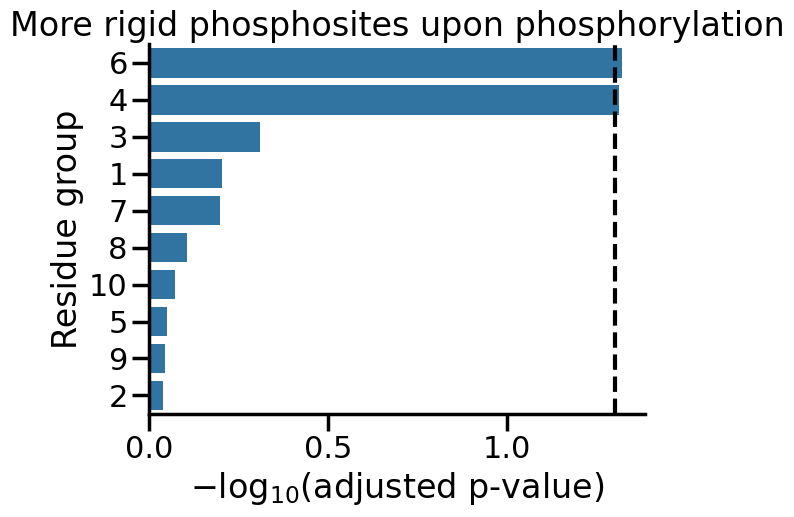

In [68]:
sns.barplot(data=merged_dec,x='-log10_adj_pval',y='key_0',color='tab:blue')
plt.axvline(sig_threshold,ls='--',color='black')
sns.despine()

plt.ylabel('Residue group')
plt.xlabel("$-\log_{10}$(adjusted p-value)")
plt.title('More rigid phosphosites upon phosphorylation')

plt.savefig(out_path / "residue_groups_decrease.pdf",dpi=120,bbox_inches='tight')